In [1]:
import torch
import joblib
import numpy as np
from torch import nn
import torch.optim as optim
from pathlib import Path
from data.data_loader import DroneGraphDataset
from models.pretrained_model_loader import load_pretrained_traj_model, extract_context_embeddings, extract_decoder_embeddings
from models.tgn import DroneRelationModel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = DroneGraphDataset(
    trajectory_csv='data/drone_states.csv',
    relationship_csv='data/drone_relations.csv',
    lookback=50,
    device=device,
)

sample = dataset[0]
print(sample['context_window'].shape)    # [50, num_drones, 4]
print(sample['current_features'].shape)  # [num_drones, 4]
print(sample['relationships'].shape)     # [num_pairs, 2]
print(sample['labels'].shape)            # [num_pairs]


[Skipping] Flight 0, timestep 33.567 has 4 drones
[Skipping] Flight 2, timestep 31.267 has 1 drones
[Skipping] Flight 4, timestep 33.2 has 1 drones
[Skipping] Flight 5, timestep 33.567 has 2 drones
[Skipping] Flight 6, timestep 33.467 has 4 drones
[Skipping] Flight 7, timestep 29.233 has 3 drones
[Skipping] Flight 8, timestep 33.1 has 2 drones
[Skipping] Flight 9, timestep 27.367 has 5 drones
[Skipping] Flight 10, timestep 28.233 has 5 drones
[Skipping] Flight 11, timestep 26.7 has 2 drones
[Skipping] Flight 12, timestep 35.067 has 3 drones
[Skipping] Flight 14, timestep 33.667 has 5 drones
[Skipping] Flight 15, timestep 30.933 has 1 drones
[Skipping] Flight 16, timestep 31.533 has 2 drones
[Skipping] Flight 17, timestep 28.0 has 1 drones
[Skipping] Flight 18, timestep 31.133 has 1 drones
[Skipping] Flight 20, timestep 26.9 has 4 drones
[Skipping] Flight 21, timestep 32.833 has 5 drones
[Skipping] Flight 22, timestep 32.667 has 1 drones
[Skipping] Flight 23, timestep 29.4 has 2 drones


In [3]:
# Example usage
experiment_dir = Path("experiments/20251015_134311")

# Load model + config
model, config = load_pretrained_traj_model(experiment_dir, device)

# Load scalers
scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# Dummy trajectory data (replace with your actual drone trajectory segment)
dummy_data = np.random.rand(100, 6 * 3).astype(np.float32)  # 100 timesteps, 6 drones, xyz

# Extract embeddings
context_emb = extract_context_embeddings(
    model,
    traj_data=dummy_data,
    scaler_X=scaler_X,
    lookback=config["LOOK_BACK"],
    features_per_agent=3,
    device=device,
)

print("Context embeddings shape:", context_emb.shape)

Context embeddings shape: torch.Size([6, 128])


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
from torch.utils.data import Subset

flight_ids = dataset.flights
num_train = int(0.8 * len(flight_ids))
train_flights = flight_ids[:num_train]
test_flights = flight_ids[num_train:]

train_indices = [i for i, (fid, _) in enumerate(dataset.valid_indices) if fid in train_flights]
test_indices = [i for i, (fid, _) in enumerate(dataset.valid_indices) if fid in test_flights]

train_ds = Subset(dataset, train_indices)
test_ds = Subset(dataset, test_indices)

In [5]:
def train_epoch(model, loader, optimizer, criterion, scaler_X, pretrained_model, config):
    model.train()
    total_loss = 0
    for batch in loader:
        context_window = batch["context_window"].squeeze(0).cpu().numpy()  # [50, num_drones, 4]
        current_features = batch["current_features"].squeeze(0).to('cpu')
        relationships = batch["relationships"].squeeze(0).to('cpu')
        labels = batch["labels"].squeeze(0).float().to('cpu')

        # Extract context embeddings from pretrained model
        context_emb = extract_decoder_embeddings(
            pretrained_model,
            traj_data=context_window[:, :, :3].reshape(50, -1),
            scaler_X=scaler_X,
            lookback=config["LOOK_BACK"],
            features_per_agent=3,
            device='cpu',
        )

        preds = model(current_features, context_emb, relationships)
        loss = criterion(preds, labels)
        
        # custom weighting
        # weights = torch.where(labels == 1, 2.0, 1.0)  # higher weight for 1s
        # loss = (weights * loss).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

@torch.no_grad()
def evaluate(model, loader, scaler_X, pretrained_model, config, show_confusion=True):
    model.eval()
    preds_all, labels_all = [], []

    for batch in loader:
        context_window = batch["context_window"].squeeze(0).cpu().numpy()
        current_features = batch["current_features"].squeeze(0).to("cpu")
        relationships = batch["relationships"].squeeze(0).to("cpu")
        labels = batch["labels"].squeeze(0).float().to("cpu")

        context_emb = extract_decoder_embeddings(
            pretrained_model,
            traj_data=context_window[:, :, :3].reshape(50, -1),
            scaler_X=scaler_X,
            lookback=config["LOOK_BACK"],
            features_per_agent=3,
            device=device,
        )

        preds = model(current_features, context_emb, relationships)
        preds_all.append(preds)
        labels_all.append(labels)

    preds_all = torch.cat(preds_all)
    labels_all = torch.cat(labels_all)

    # Binary predictions
    y_true = labels_all.cpu().numpy().astype(int)
    y_pred = (preds_all.cpu().numpy() > 0.5).astype(int)

    # Compute accuracy
    acc = (y_true == y_pred).mean().item()

    if show_confusion:
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
        disp.plot(cmap="Blues", colorbar=False)
        plt.title("Confusion Matrix")
        plt.show()

        # Optional: print precision/recall/F1
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    return acc

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


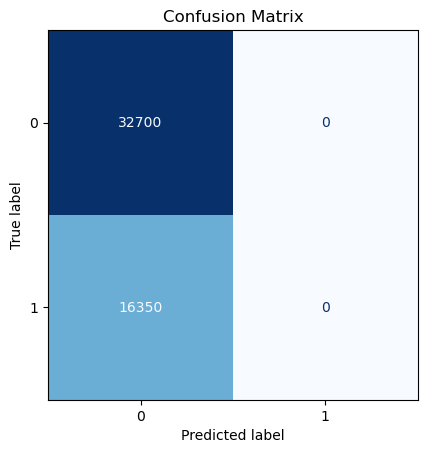

Precision: 0.000, Recall: 0.000, F1: 0.000
Epoch 1: Loss=0.6365, Test Acc=0.667


KeyboardInterrupt: 

In [7]:
# Load pretrained trajectory model
model_traj, config = load_pretrained_traj_model(experiment_dir, device)
scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# Initialize new relation model
relation_model = DroneRelationModel(context_dim=model_traj.dec_hidden_size).to(device)

optimizer = optim.Adam(relation_model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# Training loop
for epoch in range(10):
    loss = train_epoch(relation_model, train_ds, optimizer, criterion, scaler_X, model_traj, config)
    acc = evaluate(relation_model, test_ds, scaler_X, model_traj, config)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Test Acc={acc:.3f}")
